<a href="https://colab.research.google.com/github/jermwatt/machine_learning_refined/blob/main/notes/13_Multilayer_perceptrons/13_6_Batch_normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 13: Multi-layer Perceptrons 

# 13.6 Batch Normalization

Previously in [Section 9.3](https://jermwatt.github.io/machine_learning_refined/notes/9_Feature_engineer_select/9_3_Scaling.html), when dealing with linear supervised, learning we saw how normalizing each input feature of a dataset significantly aids in parameter tuning by improving the shape of a cost function's contours (making them more 'circular').  Another way of saying this is that we normalized *every distribution that touches a model parameter* - which in the linear case consists of the distribution of each input feature.   The intuition that normalizing parameter touching distributions aids in effective parameter tuning carries over completely from the linear learning scenario to our current situation - where we are conducting nonlinear learning via multi-layer perceptrons.  The difference here is that now we have many more parameters (in comparison to the linear case) and many of these parameters are *internal* as opposed to weights in a linear combination alone.  Nonetheless each parameter - as we detail here - touches a distribution that when normalized tends to improve optimization speed, particularly when using first order methods (those detailed in Chapter 3).  

Specifically - as we will investigate here in the context of the multi-layer perceptron - to completely carry over the idea of input normalization to our current scenario we will need to *standard normalize the output of each and every network activation*.  Moreover since these activation distributions naturally change during parameter tuning - e.g., whenever a gradient descent step is made - we must normalize these internal distributions every time we make a parameter update.  This leads to the incorporation of a normalization step grafted directly onto the architecture of the multi-layer perceptron itself - which is called every time weights are changed.  This natural extension of input normalization is popularly referred to as *batch normalization*.

In [1]:
# import standard libs
import os

# if on collab pull required subdirectories
if os.getenv("COLAB_RELEASE_TAG"): 
    # install github clone - allows for easy cloning of subdirectories
    !pip install github-clone
    from pathlib import Path 

    # clone datasets
    if not Path('chapter_13_datasets').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/13_Multilayer_perceptrons/chapter_13_datasets
    else:
        print('chapter_13_datasets already cloned!')

    # clone library subdirectory
    if not Path('chapter_13_library').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/13_Multilayer_perceptrons/chapter_13_library
    else:
        print('chapter_13_library already cloned!')

    # clone images
    if not Path('chapter_13_images').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/13_Multilayer_perceptrons/chapter_13_images
    else:
        print('chapter_13_images already cloned!')

    # clone videos
    if not Path('chapter_13_videos').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/13_Multilayer_perceptrons/chapter_13_videos
    else:
        print('chapter_13_videos already cloned!')

# append path for local library, data, and image import
import sys
sys.path.append('./chapter_13_library') 

# backend file
import nonlinear_classification_visualizer, perceptron_scaling_tools
from multilayer_med_library import superlearn_setup

# data path
import pickle
data_path_1 = 'chapter_13_datasets/2_eggs.csv'
data_path_2 = 'chapter_13_datasets/13_2_single_layer_weights.p'
data_path_3 = 'chapter_13_datasets/13_2_multi_layer_weights.p'
data_path_4 = 'chapter_13_datasets/mnist_test_contrast_normalized.pickle'

# video paths
video_path_1 = 'chapter_13_videos/animation_1.mp4'
video_path_2 = 'chapter_13_videos/animation_2.mp4'
video_path_3 = 'chapter_13_videos/animation_3.mp4'
video_path_4 = 'chapter_13_videos/animation_4.mp4'

# standard imports
import matplotlib.pyplot as plt
from IPython.display import Image, HTML
from matplotlib import gridspec
import autograd.numpy as np
from base64 import b64encode

def show_video(video_path, width = 1000):
    video_file = open(video_path, "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width={width} controls><source src="{video_url}"></video>""")

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## Batch normalization

In [Section 9.3](https://jermwatt.github.io/machine_learning_refined/notes/9_Feature_engineer_select/9_3_Scaling.html) we described *standard normalization*, a simple technique for normalizing a *linear model* that makes minimizing cost functions involving linear models considerably easier.  With our generic linear model

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{w}\right) = w_0 + x_1w_1 + \cdots  + x_Nw_N
\end{equation}

standard normalization involves normalizing the distribution of each input dimension of a dataset of $P$ points e.g., for the $n^{th}$ dimension we make the substitution

\begin{equation}
x_{p,n}  \longleftarrow \frac{x_{p,n}  - \mu_{n}}{\sigma_{n}}
\end{equation}

for each input where $\mu_n$ and $\sigma_n$ are the mean and standard deviation along the $n^{th}$ feature of the input, respectively.  Importantly, note that we did *not* perform any kind of normalization to the constant values touching the *bias* weight $w_0$.

*Batch normalization* takes this basic standard normalization concept and naturally extends it to models employing multi-layer perceptrons, and provides analagous benefits when optimizing cost functions employing such models.  Suppose we take our generic model involving $B = U_{L}$ generic $L$ layer mulit-layer perceptron units $f_1^{(L)},\,f_2^{(L)},\,...f_{U_L}^{(L)}$ as described in the previous Section

\begin{equation}
\text{model}\left(\mathbf{x},\Theta\right) = w_0^{\,} + f_1^{(L)}\left(\mathbf{x}\right)w_1^{\,} + \cdots + f_{U_L}^{(L)}\left(\mathbf{x}\right)w_{U_L}^{\,}
\end{equation}

and try to extend the standard normalization scheme in introduced in Section 9.2 to every non-bias weight touching distribution of our model.  Of course here the *input features*, or dimensions of our input, no longer touch the weights of the linear combination $w_1,...,w_{U_L}$, they instead touch the weights *internal to the first layer of the multi-layer perceptron units themselves*.  We can see this by analyzing the $j^{th}$ single layer unit in this network 

\begin{equation}
f^{(1)}_j\left(\mathbf{x}\right)=a\left(w^{\left(1\right)}_{0,\,j}+\underset{n=1}{\overset{N}{\sum}}{w^{\left(1\right)}_{n,\,j}\,x^{\,}_n}\right)
\end{equation}

that in such a model the $n^{th}$ dimension of the input $x_n$ touches the single layer weight $w^{\left(1\right)}_{n,\,j}$ (and not e.g., a weight of the final linear combination).  Thus in standard normalizing the input we only directly affect the contours of a cost function employing a multi-layer perceptron along the weights internal to the single layer elements.  To affect the contours of a cost function with respect to weights external to the first hidden layer (via standard normalizing) we must naturally *standard normalize the output of the first hidden layer*.

For the sake of simplicity, suppose for a moment $L=1$, and thus our model takes the form
$\text{model}\left(\mathbf{x},\Theta\right) = w_0^{\,} + f_1^{(1)}\left(\mathbf{x}\right)w_1^{\,} + \cdots + f_{U_1}^{(1)}\left(\mathbf{x}\right)w_{U_1}^{\,}$ and so the distribution $\left\{f^{(1)}_j\left(\mathbf{x}_p\right) \right\}_{p=1}^P$ *directly touches the final linear combination weight $w_j$*.  In our quest to fully apply the principle of *standard normalization* to our multi-layer perceptron model we would then naturally want to *standard normalize the output of our first hidden layer* (i.e., for each unit $j =1,...,U_1$) as

\begin{equation}
f_j^{(1)} \left(\mathbf{x} \right) \longleftarrow \frac{f_j^{(1)} \left(\mathbf{x}\right) - \mu_{f_j^{(1)}}}{\sigma_{f_j^{(1)}}}
\end{equation}

where

\begin{array}
\
\mu_{f_j^{(1)}} = \frac{1}{P}\sum_{p=1}^{P}f_j^{(1)}\left(\mathbf{x}_p \right) \\
\sigma_{f_j^{(1)}} = \sqrt{\frac{1}{P}\sum_{p=1}^{P}\left(f_j^{(1)}\left(\mathbf{x}_p \right) - \mu_{f_j^{(1)}} \right)^2}.
\end{array}

This is certainly easy to accomplish.  However it is important to note that - unlike our input features - the output of the single hidden layer (and hence its distribution) changes *every time the internal parameters of our model are changed like e.g., during each step of gradient descent*.  The constant alteration of this distribution of single layer units - called *internal covariate shift* or just *covariate shift* in the jargon of machine learning - implies that if we are to carry over the principle of standard normalization completely we will need to standard normalize the output of the first hidden layer *at every step of parameter tuning (e.g., via gradient descent)*.  In other words, we need to build *standard normalization* directly into the perceptron architecture itself.

We show a generic recipe for doing just this - a simple extension of the recipe for single layer units given in the previous Section - below.

#### Recursive rescipe for batch normalized single layer perceptron units

<hr style="height:1px;border:none;color:#555;background-color:#555;">
<p style="line-height: 1.7;">
<strong>1:</strong>&nbsp;&nbsp; <strong>input:</strong> Activation function $a\left(\cdot\right)$ and input data $\left\{\mathbf{x}_p\right\}_{p=1}^P$<br>

<strong>2:</strong>&nbsp;&nbsp; Compute linear combination:   $\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,v = w_{0}^{(1)}+{\sum_{n=1}^{N}}{w_{n}^{(1)}\,x_n}$ <br>

<strong>3:</strong>&nbsp;&nbsp; Pass result through activation: $\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, f^{(1)}\left(\mathbf{x}\right) =  a\left(v\right)$ <br>

<strong>4:</strong>&nbsp;&nbsp; Compute mean: $\mu_{f^{(1)}}$ / standard deviation $\sigma_{f^{(1)}}$ of: $\,\,\,\,\,\,\,\,\left\{f^{(1)}\left(\mathbf{x}_p\right) \right\}_{p=1}^P$ <br>

<strong>5:</strong>&nbsp;&nbsp; Standard normalize: $ \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,
f^{(1)} \left(\mathbf{x} \right) \longleftarrow \frac{f^{(1)} \left(\mathbf{x}\right) - \mu_{f^{(1)}}}{\sigma_{f^{(1)}}}
$ <br>

<strong>6:</strong>&nbsp;&nbsp; <strong>output:</strong> Batch normalized single layer unit $\,\, f^{(1)} \left(\mathbf{x} \right)$<br/>

<hr style="height:1px;border:none;color:#555;background-color:#555;">
</p>

#### <span style="color:#a50e3e;">Example 1. </span>  The shifting distributions / internal covariate shift of a single layer perceptron model

In this example we illustrate the *covariate shift* of a single layer perceptron model using two ReLU units $f^{(1)}_1$ and $ f^{(1)}_2$, applied to performing two-class classification using the toy two-class classification dataset shown below.  

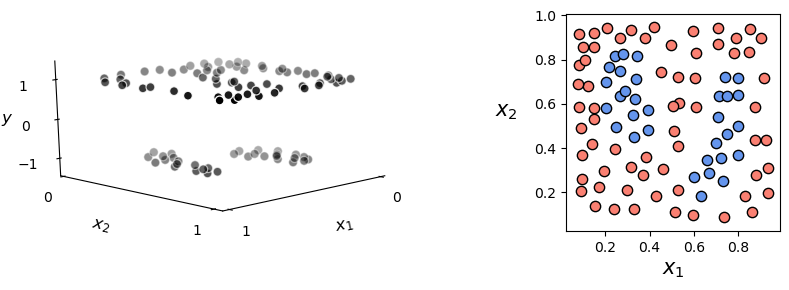

In [3]:
# load in toy classification dataset
viewer = nonlinear_classification_visualizer.Visualizer(data_path_1)
x = viewer.x.T
y = viewer.y[np.newaxis,:]

# plot toy classification data
viewer.plot_data()

We now run $5,000$ steps of gradient descent to minimize the softmax cost using this single layer network, where we standard normalize the input data.  We use a set of random weights for the network loaded in from memory.

In [6]:
# load in a set of random weights from memory
w = pickle.load( open(data_path_2, "rb" ) )

# import the v1 library
mylib1 = superlearn_setup.Setup(x,y)

# choose features
mylib1.choose_features(name = 'multilayer_perceptron',layer_sizes = [2,2,1],activation = 'relu')

# choose normalizer
mylib1.choose_normalizer(name = 'standard')

# choose cost
mylib1.choose_cost(name = 'softmax')

# fit an optimization
mylib1.fit(max_its = 5000,alpha_choice = 10**(-1),w_init = w)

Below we show an animation of this gradient descent run, plotting the single unit distribution $\left\{f^{(1)}_1\left(\mathbf{x}_p\right),\,f^{(1)}_2\left(\mathbf{x}_p\right)  \right\}_{p=1}^P$ at a subset of the steps taken during the run.  In the left panel we show this *covariate shift* or activation output distribution at the $k^{th}$ step of the optimization, while the right panel shows the complete cost function history curve where the current step of the animated optimization is marked on the curve with a red dot.  Moving the slider from left to right progresses the run from start to finish.

In [5]:
# # uncomment and run to re-render animation
# # show a plot of the distribution of activation outputs of a single layer perceptron
# frames = 200
# demo1 = feature_plotter.Visualizer()
# demo1.shifting_distribution(video_path_1,mylib1,frames,x,show_history = True,fps=20)

In [2]:
show_video(video_path_1)

As you can see by moving the slider around, the distribution of activation outputs - i.e., the distributions touching the weights of our model's linear combination $w_0$ and $w_1$ - change dramatically as the gradient descent algorithm progresses.  We can intuit (from our previous discussions on input normalization) that this sort of shifting distribution negatively effects the speed at which gradient descent can properly minimize our cost function.

Now we repeat the above experiment using the batch normalized single layer perceptron - making a run of $10,000$ gradient descent steps using the same initialization used above.  We then animate the covariate shift / distribution of activation outputs using the same animation tool used above as well.  Moving the slider below from left to right - progressing the algorithm - we can see here that the distribution of activation outputs stays considerably more stable. 

In [7]:
# load in a set of random weights from memory
w = pickle.load( open(data_path_2, "rb" ) )

# import the v1 library
mylib2 = superlearn_setup.Setup(x,y)

# choose features
mylib2.choose_features(name = 'multilayer_perceptron_batch_normalized',layer_sizes = [2,2,1],activation = 'relu')

# choose normalizer
mylib2.choose_normalizer(name = 'standard')

# choose cost
mylib2.choose_cost(name = 'softmax')

# fit an optimization
mylib2.fit(max_its = 5000,alpha_choice = 10**(-1),w_init = w)

# # uncomment and run to re-render animation
# # show a plot of the distribution of each feature
# frames = 200
# demo2 = feature_plotter.Visualizer()
# demo2.shifting_distribution(video_path_2,mylib2,frames,x,show_history = True,normalize = True,fps=20)

In [3]:
show_video(video_path_2)

#### <span style="color:#a50e3e;">Example 2. </span>  Comparing original and batch normalized single layer models on a subset of MNIST

In this example we illustrate the benefit of batch normalization in terms of speeding up optimization via gradient descent on a dataset of $10,000$ handwritten digits from the MNIST dataset.  Each image in this dataset has been *contrast normalized*, a common preprocessing step for image dataset we discuss later in the context of convolutional networks.  Here we show $100$ steps of gradient descent, with the largest steplength of the form $10^{-\gamma}$ for integer $\gamma$ we found produced adequate convergence, comparing the standard to batch normalized versions of a network with `relu` activation and a single layer architecture with 100 units  Here we can see that both in terms of cost function value and number of misclassifications the batch normalized version of the perceptron allows for much more rapid minimization via gradient descent than the original version. 

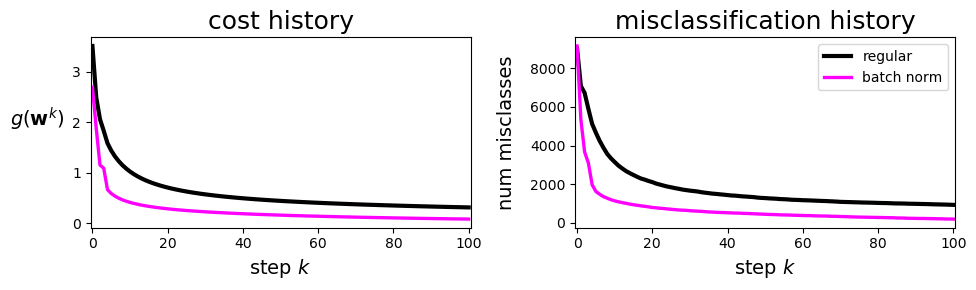

In [13]:
# load in mnist test set
with open(data_path_4, 'rb') as input_file:
    data = pickle.load(input_file)
    
x = data[0]
y = data[1]

# import the v1 library
mylib3 = superlearn_setup.Setup(x,y)

# choose features
layer_sizes = [784,100,10]; scale = 0.1;
mylib3.choose_features(name = 'multilayer_perceptron',layer_sizes = layer_sizes, scale = scale, activation = 'relu')

# choose normalizer
mylib3.choose_normalizer(name = 'standard')

# choose cost
mylib3.choose_cost(name = 'multiclass_softmax')

# fit an optimization
mylib3.fit(max_its = 100,alpha_choice = 10**(-1))

##### run batch normalized version #####
# choose features
mylib3.choose_features(name = 'multilayer_perceptron_batch_normalized',layer_sizes = layer_sizes,scale = scale,activation = 'relu')

# choose normalizer
mylib3.choose_normalizer(name = 'standard')

# choose cost
mylib3.choose_cost(name = 'multiclass_softmax')

# fit an optimization
mylib3.fit(max_its = 100,alpha_choice = 10**(0))

# plot cost history
mylib3.show_histories(start = 0,labels = ['regular','batch norm'])

---

If we now kick up the depth of our network by one layer, setting $L=2$, i.e., our model consists of $U_2$ two layer units as $\text{model}\left(\mathbf{x},\Theta\right) = w_0^{\,} + f_1^{(2)}\left(\mathbf{x}\right)w_1^{\,} + \cdots + f_{U_2}^{(2)}\left(\mathbf{x}\right)w_{U_2}^{\,}$ which are likewise composed of $U_1$ single layer units (as detailed in the previous Section), we will see that we still want to standard normalize the output of our first hidden layer.  Writing out the $j^{th}$ element of our second hidden layer

\begin{equation}
f^{\left(2\right)}_j\left(\mathbf{x}\right)=a\left(w^{\left(2\right)}_{0,\,j}+\underset{i=1}{\overset{U_1}{\sum}}{w^{\left(2\right)}_{i,\,j}}\,f^{(1)}_i\left(\mathbf{x}\right) \right)
\end{equation}

we can see that - in extending the notion of standard normalization introduced in Section 9.2 to any non-bias weight touching distribution of our model - that by standard normalizing the first layer output we are normalizing the distribution touching the non-bias weights belonging to the second layer (i.e., the weights $w_{i,\,j}^{(2)}$).  However now - in our $L=2$ layer model - the output of the *second layer* touches the linear combination weights $w_1$ through $w_{U_2}$.  Thus - in keepinng with our desire to extend standard normalization - we will want to *standard normalize our second layer output as well* (and - again - re-normalize it every time we adjust the parameters of our model, like e.g., during each step of gradient descent).

In extending the principle of standard normalization precisely the same argument can be made for our general $L$ layer model $\text{model}\left(\mathbf{x},\Theta\right) = w_0^{\,} + f_1^{(L)}\left(\mathbf{x}\right)w_1^{\,} + \cdots + f_{U_L}^{(L)}\left(\mathbf{x}\right)w_{U_L}^{\,}$.  That is, we will want to *standard normalize the output of every layer of the network*.  Thus in general, for layer $L$ units once we have standard normalized the outupt of every layer preceeding it we normalize the $j^{th}$ unit of the $L^{th}$ layer

\begin{equation}
f^{\left(L\right)}_j\left(\mathbf{x}\right)=a\left(w^{\left(L\right)}_{0,\,j}+\underset{i=1}{\overset{U_L}{\sum}}{w^{\left(2\right)}_{i,\,j}}\,f^{(L-1)}_i\left(\mathbf{x}\right) \right)
\end{equation}

via standard normalizing as

\begin{equation}
f^{(L)}_j \left(\mathbf{x} \right) \longleftarrow \frac{f^{(L)}_j \left(\mathbf{x}_p\right) - \mu_{f^{(L)}_j}}{\sigma_{f^{(L)}_j}}
\end{equation}

where

\begin{array}
\
\mu_{f^{(L)}_j} = \frac{1}{P}\sum_{p=1}^{P}f^{(L)}_j\left(\mathbf{x}_p \right) \\
\sigma_{f^{(L)}_j} = \sqrt{\frac{1}{P}\sum_{p=1}^{P}\left(f^{(L)}_j\left(\mathbf{x}_p \right) - \mu_{f^{(L)}_j} \right)^2}.
\end{array}

In summary, in order to extend the standard normalization scheme first introduced in Section 9.2 for models employing multi-layer perceptron units we standard normalize both the input to the model as well as *the output of every layer in the network*.  Moreover, the normalization of each layer output must be performed every time the model parameters are altered, e.g., during each step of optimization.  This extension of standard normalization is referred to in the jargon of machine learning as *batch normalizing* or *batch normalization*.  Note: when employing a stochastic or mini-batch first order method is emloyed *normalization of the architecture is performed as detailed above on each mini-batch*.

With such a simple adjustment we can still construct each *batch normalized* perceptron unit recursively, since all we must do is insert a standard normalization step into the end of each layer as summarized below. 

#### Recursive rescipe for batch normalized $L$ layer perceptron units

<hr style="height:1px;border:none;color:#555;background-color:#555;">
<p style="line-height: 1.7;">
<strong>1:</strong>&nbsp;&nbsp; <strong>input:</strong> Activation function $a\left(\cdot\right)$, number of $\left(L-1\right)$ layer units $U_{L-1}$<br>

<strong>2:</strong>&nbsp;&nbsp;  Construct $\left(L-1\right)$ layer batch normalized units:  $\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,f^{(L-1)}_i\left(\mathbf{x}\right)$ for $i=1,\,...,U_{L-1}$ <br>

<strong>3:</strong>&nbsp;&nbsp; Compute linear combination:   $\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, v = w_{0}^{(L)}+{\sum_{i=1}^{U_{L-1}}}{w_{i}^{(L)}\,f^{(L-1)}_i}\left(\mathbf{x}\right)$ <br>

<strong>4:</strong>&nbsp;&nbsp; Pass result through activation: $\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, f^{(L)}\left(\mathbf{x}\right) =  a\left(v\right)$ <br>

<strong>5:</strong>&nbsp;&nbsp; Compute mean: $\mu_{f^{(L)}}$ / standard deviation $\sigma_{f^{(L)}}$ of: $\,\,\,\,\,\,\,\,\left\{f^{(L)}\left(\mathbf{x}_p\right) \right\}_{p=1}^P$ <br>

<strong>6:</strong>&nbsp;&nbsp; Standard normalize: $ \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,
f^{(L)} \left(\mathbf{x} \right) \longleftarrow \frac{f^{(L)} \left(\mathbf{x}\right) - \mu_{f^{(L)}}}{\sigma_{f^{(L)}}}
$ <br>

<strong>7:</strong>&nbsp;&nbsp; <strong>output:</strong> Batch normalized $L$ layer unit $\,\, f^{(L)} \left(\mathbf{x} \right)$<br/>

<hr style="height:1px;border:none;color:#555;background-color:#555;">
</p>

**Note:** in practice one often *parameterizes* the standard normalization of each unit e.g., for an $L$ layer unit as

\begin{equation}
f^{(L)} \left(\mathbf{x} \right) \longleftarrow \alpha\frac{f^{(L)} \left(\mathbf{x}\right) - \mu_{f^{(L)}}}{\sigma_{f^{(L)}}} + \beta
\end{equation}

and it is this parameterized standard normalization scheme which is often referred to as *batch normalization*.  Including parameters provides more flexibility than the unparameterized form we discuss here.   Because the heart of batch normalization lies is the standard normalization procedure itself we have introduced it unparameterized.  Even without these extra parameters however significant improvement in optimization speed can seen in multi-perceptron based models with the employment of batch normalization.

#### <span style="color:#a50e3e;">Example 3. </span>  The shifting distributions / covariate shift of a multilayer perceptron

In this example we illustrate the covariate shift of a standard $4$ layer multilayer perceptron with two units per layer, using the `tanh` activation and the same dataset employed in the previous example.  We then compare this to the covariate shift present in the batch normalized version of the network.  Since each layer has just two units we can plot the distribution of activation outputs of each layer, visualizing the covariate shift.  As in the previous example we make a run of $10,000$ gradient descent steps and animate the covariate shift of all $4$ layers of the network via a slider mechanism.

Below we animate the run of gradient descent.  As with the animation in the previous example, the covariate shift of this network - shown in the left panel below - is considerable.  As you move the slider from left to right you can track which step of gradient descent is being illustrated by the red point shown on the cost function history in the right panel (as you pull the slider from left to right the run is animated from start to finish).

Each layer's units' distribution is shown in this panel, with the output of the first layer $\left(f_1^{(1)},f_2^{(1)}\right)$ are colored in cyan, the second layer $\left(f_1^{(2)},f_2^{(2)}\right)$ is colored magenta, the third layer $\left(f_1^{(3)},f_2^{(3)}\right)$ colored lime green, and the fourth layer $\left(f_1^{(4)},f_2^{(4)}\right)$ is shown in orange.  In analogy to the animation shown above for a single layer network, here the horizontal and vertical quantities of each point shown represent the activation output of the first and second unit respectively for each layer. 

In [10]:
# load in data
data = np.loadtxt(data_path_1,delimiter = ',')

# get input/output pairs
x = data[:-1,:]
y = data[-1:,:] 

# import the v1 library
mylib4 = superlearn_setup.Setup(x,y)

# choose features
mylib4.choose_features(name = 'multilayer_perceptron',layer_sizes = [2,2,2,2,2,1],activation = 'tanh',scale=1)

# choose normalizer
mylib4.choose_normalizer(name = 'standard')

# choose cost
mylib4.choose_cost(name = 'softmax')

# fit an optimization"
mylib4.fit(max_its = 30000,alpha_choice = 10**(-2))

# # uncomment and run to re-render animation
# # show a plot of the distribution of each feature
# frames = 200
# demo3 = feature_plotter.Visualizer()
# demo3.shifting_distribution(video_path_3,mylib4,frames,x,show_history = True,fps=20)

In [4]:
show_video(video_path_3)

Performing batch normalization on each layer of this network helps considerably in taming this covariate shift.  Below we run the same experiment, using the same initialization, activation, and dataset using the batch normalized version of the network.  Afterwards we again animate the covariate shift for a subset of the steps of gradient descent.

Moving the slider from left to right below progresses the animation from the start to finish of the run.  Scanning over the entire range of steps we can see in the left panel that the distribution of each layer's activation outputs remains much more stable than previously.

In [12]:
# load in data
data = np.loadtxt(data_path_1,delimiter = ',')

# get input/output pairs
x = data[:-1,:]
y = data[-1:,:] 

# import the v1 library
mylib5 = superlearn_setup.Setup(x,y)

# choose features
mylib5.choose_features(name = 'multilayer_perceptron_batch_normalized',layer_sizes = [2,2,2,2,2,1],activation = 'tanh')

# choose normalizer
mylib5.choose_normalizer(name = 'standard')

# choose cost
mylib5.choose_cost(name = 'softmax')

# fit an optimization
mylib5.fit(max_its = 30000,alpha_choice = 10**(-2),w_init = mylib4.w_init)

# # uncomment and run to re-render animation
# # show a plot of the distribution of each feature
# frames = 200
# demo4 = feature_plotter.Visualizer()
# demo4.shifting_distribution(video_path_4,mylib5,frames,x,show_history = True,normalize = True,fps=20)

In [5]:
show_video(video_path_4)

#### <span style="color:#a50e3e;">Example 4. </span>  Comparing original and batch normalized multilayer layer models on a subset of MNIST

In this example we illustrate the benefit of batch normalization in terms of speeding up optimization via graident descent on a dataset of $10,000$ handwritten digits from the MNIST dataset.  Each image in this dataset has been *contrast normalized*, a common preprocessing step for image dataset we discuss later in the context of convolutional networks.  Here we show $100$ steps of gradient descent, with the largest steplength of the form $10^{-\gamma}$ for integer $\gamma$ we found produced adequate convergence, comparing the standard to batch normalized versions of a network with `relu` activation and a three layer architecture with 10 units per layer.  Here we can see that both in terms of cost function value and number of misclassifications the batch normalized version of the perceptron allows for much more rapid minimization via gradient descent than the original version. 

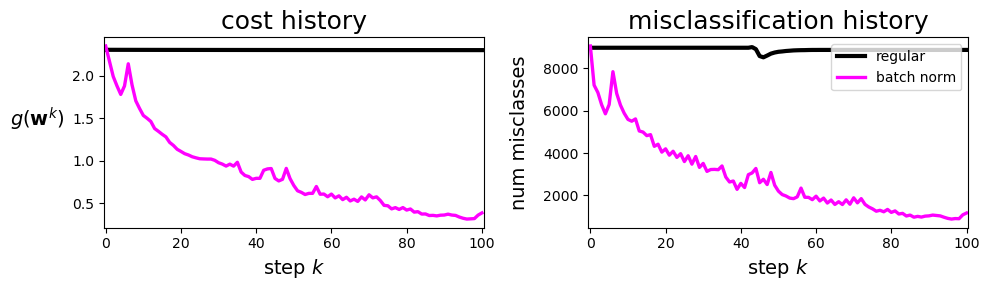

In [19]:
# load in mnist test set
with open(data_path_4, 'rb') as input_file:
    data = pickle.load(input_file)
    
x = data[0]
y = data[1]

# import the v1 library
mylib6 = superlearn_setup.Setup(x,y)

# choose features
layer_sizes = [784,10,10,10,10,10]; scale = 0.1;
mylib6.choose_features(name = 'multilayer_perceptron',layer_sizes = layer_sizes, scale = scale, activation = 'relu')

# choose normalizer
mylib6.choose_normalizer(name = 'standard')

# choose cost
mylib6.choose_cost(name = 'multiclass_softmax')

# fit an optimization
mylib6.fit(max_its = 100,alpha_choice = 10**(-1))

##### run batch normalized version #####
# choose features
mylib6.choose_features(name = 'multilayer_perceptron_batch_normalized',layer_sizes = layer_sizes,scale = scale,activation = 'relu')

# choose normalizer
mylib6.choose_normalizer(name = 'standard')

# choose cost
mylib6.choose_cost(name = 'multiclass_softmax')

# fit an optimization
mylib6.fit(max_its = 100,alpha_choice = 10**(0))

# plot cost history
mylib6.show_histories(start = 0,labels = ['regular','batch norm'])

##  Evaluating test points using a batch normalized network

An important point to to remember when employing a batch normalized network - which we encountered earlier in Section 9.2 in the context of standard normalization - is that we must treat test data precisely as we treat training data.  Here this means that the final normalization constants determined during training - i.e., the various means and standard deviations of the input as well as for each each layer of output activation - must be saved and re-used in order to properly evaluate new test inputs.  In other words, all normalization constants in a batch normalized network should be *fixed* to the values computed on at the final step of training (e.g., at the best step of gradient descent) when evaluating new test points.

##  Efficient Python implementation

Below we illustrate how one can implement the activation output normalization idea unwravelled above.  This is a simple extension of the implementation of the multi-layer feature transformation function `feature_transforms` given at the end of the previous Section.  In particular all, analyzing the recursive recipe for batch normalizing a general layer $L$ unit given above, we need do is add a standard normalization step to the end of the `for` loop defining each layer of the network.  This small adjustment is shown below. 

In [15]:
# a feature_transforms function for computing
# U_L L layer perceptron units efficiently
# including batch normalization of each hidden layer
def feature_transforms(a, w):    
    # loop through each layer matrix
    for W in w:
        # compute inner product with current layer weights
        a = W[0] + np.dot(a.T, W[1:])

        # output of layer activation
        a = activation(a).T
        
        # NEW - perform standard normalize 
        # the output of each layer 
        a = standard_normalize(a)
    return a

Here the new function `standard_normalize` can be written simply and applied to both the input and each layer's output.

In [16]:
# standard normalization function - input data, output standaard normalized version
def standard_normalize(data):
    # compute the mean and standard deviation of the input
    data_means = np.mean(data,axis = 1)[:,np.newaxis]
    data_stds = np.std(data,axis = 1)[:,np.newaxis]   

    # check to make sure thta x_stds > small threshold, for those not
    # divide by 1 instead of original standard deviation
    ind = np.argwhere(data_stds < 10**(-2))
    if len(ind) > 0:
        ind = [v[0] for v in ind]
        adjust = np.zeros((data_stds.shape))
        adjust[ind] = 1.0
        data_stds += adjust

    # return standard normalized data 
    return (data - data_means)/data_stds